In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit

import numpyro
import numpyro.distributions as dist
import numpyro_ext
import numpyro_ext.distributions as distx, numpyro_ext.optim as optimx
import jax
import jax.numpy as jnp
import arviz as az
import corner
import itertools

numpyro.set_host_device_count(
    2
)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)  # For 64-bit precision since JAX defaults to 32-bit

# Investigating the empirical limb darkening with JWST:

In this notebook, I will demonstrate the use of jaxoplanet to investigate empirical limb darkening using JWST light curves, focusing on the JWST NIRSpec PRISM observation of WASP-39b. I am particularly interested in how limb darkening looks towards the limb of the star, and as a function of wavelength. I am basing this work off of Jeff Valenti's talk at Know Thy Star 2, where he showed comparisons to model limb darkening coefficients for a 2 parameter limb darkening law. In order to better represent the limb darkening at the edge of the star, I will be using a high order expansion of the limb darkening as a polynomial to fit the data. 

## White light curve fit:

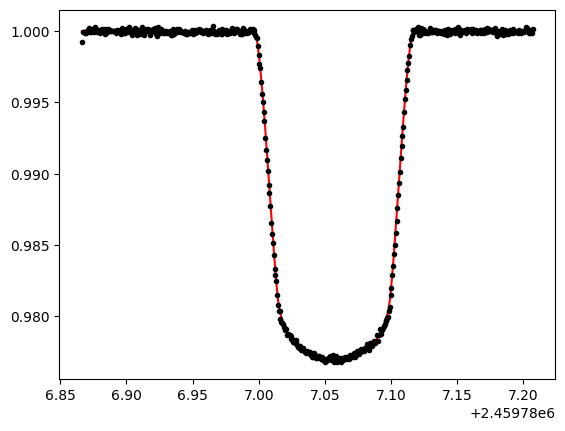

In [2]:
h5file = h5py.File(
    'ZENODO/3_SPECTROSCOPIC_LIGHT_CURVES/NIRISS_SOSS_Order1/R100/'
    'S4_wasp39b_ap0_bg0_LCData.h5')
data = np.array(h5file['data'])
wmid = np.array(h5file['wave_mid'])
time = np.array(h5file['time'])+2400000
norm = np.nanmedian(data[:,0:100], axis=1, keepdims=True)

white_lc = np.sum(data, axis=0)/np.sum(norm, axis=0)


def eval_limb_dark_light_curve(params, t):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        impact_param=params["b"],
        time_transit=params["t0"],
        radius_ratio=params["rors"],
    )
    return limb_dark_light_curve(orbit, params["u"])(t)

init_white_lc_params = {'period': 4.0552941, 'duration': 0.12, 'b': 0.4458, 't0': 2459770+0.83566341, 'rors': 0.145, 'u': jnp.array([0.2, 0.2, 0.1, 0.1]),
                        'duration_std': 0.01, 't0_std': 1e-3, 
                        'rors_std': 0.01, 'u_std': jnp.array([0.1, 0.1, 0.1, 0.1])}

model_white_lc = eval_limb_dark_light_curve(init_white_lc_params, jnp.array(time))
plt.plot(np.array(time), model_white_lc+1.0, 'r-')
plt.plot(np.array(time), white_lc, 'k.')

In [3]:
time, white_lc = jnp.array(time)[~np.isnan(white_lc)], jnp.array(white_lc)[~np.isnan(white_lc)]

In [24]:
def white_model(t, y=None):
    # Priors for the parameters we're fitting for

    # The time of reference transit
    t0 = numpyro.sample("t0", numpyro.distributions.Normal(init_white_lc_params['t0'], init_white_lc_params['t0_std']))

    # The duration
    logD = numpyro.sample("logD", numpyro.distributions.Normal(jnp.log(init_white_lc_params['duration']), init_white_lc_params['duration_std']))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # The radius ratio
    # logR = numpyro.sample("logR", numpyro.distributions.Normal(jnp.log(ROR), 0.1))
    r = numpyro.sample("r", numpyro.distributions.Uniform(0.1, 0.2))
    # r = numpyro.deterministic("r", jnp.exp(logR))

    # The impact parameter
    # b = numpyro.sample("b", numpyro.distributions.Uniform(0, 1.0))
    _b = numpyro.sample("_b", numpyro.distributions.Uniform(0, 1.0))
    b = numpyro.deterministic("b", _b * (1 + r))

    # The limb darkening coefficients
    u = numpyro.sample("u", numpyro.distributions.Uniform(jnp.array([0., 0., 0., 0.]), jnp.array([0.3, 0.3, 0.3, 0.3])))

    # The orbit and light curve
    y_pred = eval_limb_dark_light_curve(
        {"period": init_white_lc_params['period'], "duration": duration, "t0": t0, "b": b, "rors": r, "u": u}, t
    )+1.0

    jitter = numpyro.sample("jitter", numpyro.distributions.HalfNormal(0.0001))
    
    # Let's track the light curve
    numpyro.deterministic("light_curve", y_pred)

    # The likelihood function assuming Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, jitter), obs=y)

In [25]:
run_optim = numpyro_ext.optim.optimize(
        white_model,
        init_strategy=numpyro.infer.init_to_median(),
        return_info=True
    )

opt_params, status = run_optim(jax.random.PRNGKey(3), np.array(time), y=white_lc)

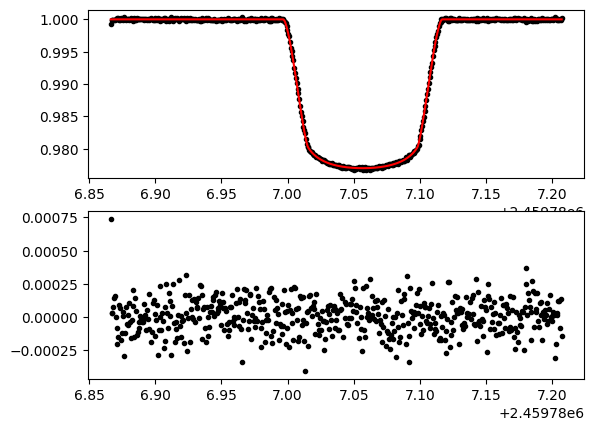

In [27]:
ax1 = plt.subplot(211)
ax1.plot(time, white_lc, 'k.')
ax1.plot(time, opt_params['light_curve'], 'r-')

ax2 = plt.subplot(212)
ax2.plot(time, opt_params['light_curve']-white_lc, 'k.')

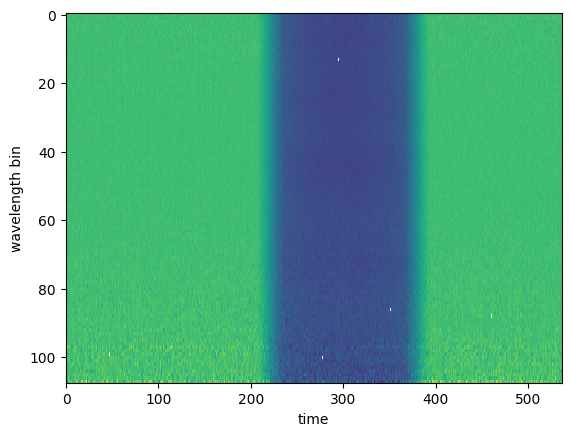

In [85]:
h5file = h5py.File(
    'ZENODO/3_SPECTROSCOPIC_LIGHT_CURVES/NIRISS_SOSS_Order1/R100/'
    'S4_wasp39b_ap0_bg0_LCData.h5')
wmid = np.array(h5file['wave_mid'])
time = np.array(h5file['time']) + 2400000
data = np.array(h5file['data'])
norm = np.nanmedian(data, axis=1, keepdims=True)
data = data/norm
err = np.array(h5file['err'])/norm
plt.imshow(data, interpolation='none', aspect='auto')
plt.ylabel("wavelength bin")
plt.xlabel("time")
plt.show()

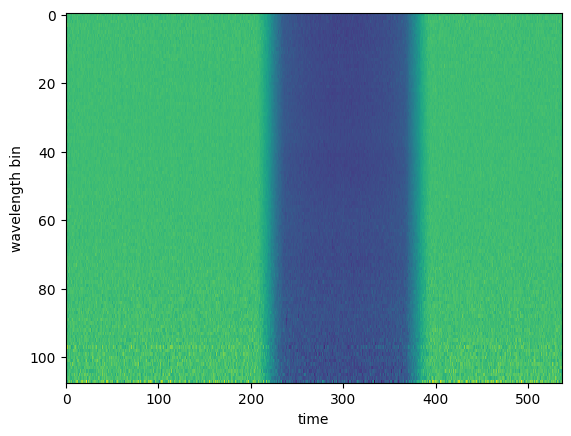

In [122]:
from scipy import interpolate
def fill_nan_interp_x(arr):
    """
    Fill NaN values in a 2D array by linear interpolation along x-axis.
    Each row is interpolated independently.
    """
    arr_filled = arr.copy()
    x = np.arange(arr.shape[1])

    for i in range(arr.shape[0]):
        row = arr[i, :]
        mask = ~np.isnan(row)  # valid values
        if mask.sum() > 1:  # need at least 2 points to interpolate
            f = interpolate.interp1d(
                x[mask], row[mask],
                kind="linear", bounds_error=False,
                fill_value="extrapolate"
            )
            arr_filled[i, :] = f(x)
        else:
            # If row has <=1 valid values, just keep it as is
            arr_filled[i, :] = row
    return arr_filled

data = fill_nan_interp_x(data)
plt.imshow(data, interpolation='none', aspect='auto')
plt.ylabel("wavelength bin")
plt.xlabel("time")
plt.show()

Text(0.5, 1.0, 'Full Spectroscopic Light Curve')

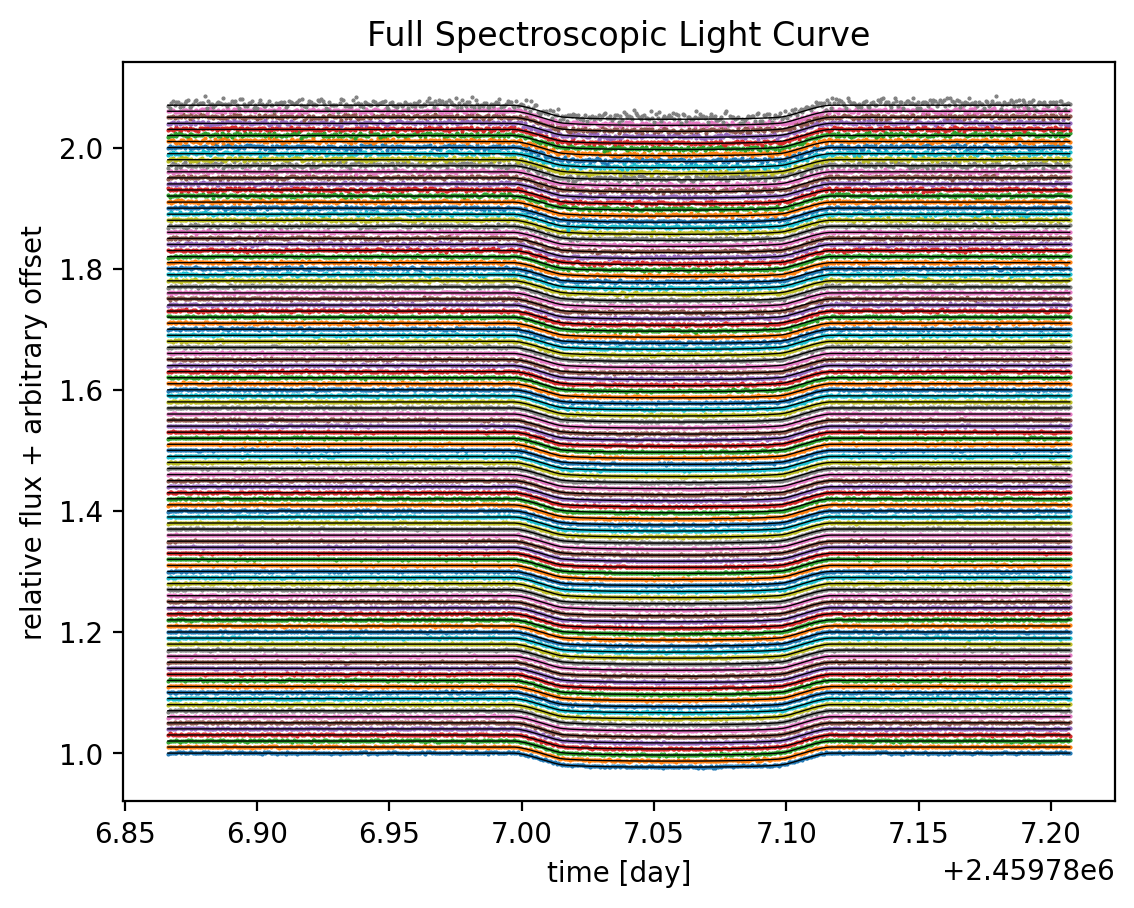

In [123]:
from scipy.stats import binned_statistic
PERIOD = init_white_lc_params['period']
DURATION = init_white_lc_params['duration']
B = init_white_lc_params['b']
T0 = init_white_lc_params['t0']
F0=jnp.ones_like(wmid)*0.0
U = init_white_lc_params['u']
RPRS = jnp.ones_like(wmid)*init_white_lc_params['rors']
params = {
    "period": PERIOD,
    "duration": DURATION,
    "b": B,
    "t0": T0,
    "u": U,
    "rors": RPRS,
    "f0":F0
}

def eval_limb_dark_light_curve(params, t):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        impact_param=params["b"],
        time_transit=params["t0"],
        radius_ratio=params["rors"],
    )
    return limb_dark_light_curve(orbit, params["u"])(t)+params["f0"]


y_true = jax.vmap(
    eval_limb_dark_light_curve,
    in_axes=(
        {
            "period": None,
            "duration": None,
            "b": None,
            "t0": None,
            "u": None,
            "rors": 0,
            "f0": 0,
        },
        None,
    ),
)(params, jnp.array(time))


# Let's check our spectroscopic light curves
fig, ax = plt.subplots(dpi=200)
offset = 0.0
for _y_true, _y, wv in zip(y_true, data, wmid):
    ax.plot(np.array(time), _y + offset, marker=".", ms=1, ls="none", lw=0.8
    )
    ax.plot(np.array(time), _y_true + offset+1.0, lw=0.5, color="k",zorder=10)
    #ax.annotate(f"{wv:.1f} $\\mu$m", xy=(time[0], 0.002 + offset), fontsize=8)
    offset += 0.01
_ = ax.set_xlabel("time [day]", fontsize=10)
_ = ax.set_ylabel("relative flux + arbitrary offset", fontsize=10)
#plt.axvline(T0, color="k", ls="--", lw=0.5)
plt.title("Full Spectroscopic Light Curve")

In [ ]:
def model(t, y_err, y=None):

    # Priors

    ## Parameters shared across spectroscopic light curves
    logD = numpyro.sample("logD", dist.Normal(jnp.log(init_white_lc_params['duration']), 1e-2))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    t0 = numpyro.sample(
        "t0", dist.Normal(init_white_lc_params['t0'], 1e-4)
    )  # We usually have pretty good constraints on t0
    b = numpyro.sample(
        "b",
        dist.TruncatedNormal(init_white_lc_params['b'], 0.1, low=0.0, high=1.0),
    )
    
    u = numpyro.sample("u", distx.QuadLDParams())

    ## Parameters for each light curve
    f0 = numpyro.sample("f0", dist.Normal(jnp.ones_like(wmid), 1e-3*jnp.ones_like(wmid)))

    depths = numpyro.sample(
        "depths",
        dist.TruncatedNormal(
            jnp.square(init_white_lc_params['rors']) * jnp.ones_like(wmid),
            1e-3 * jnp.ones_like(wmid),
            low=0.0,
            high=1.0,
        ),
    )
    rors = jnp.atleast_1d(numpyro.deterministic("rors", jnp.sqrt(depths)))

    params = {
        "period": PERIOD,
        "duration": duration,
        "t0": t0,
        "b": b,
        "u": u,
        "f0": f0,
        "rors": rors,
    }
    y_model = numpyro.deterministic("y_model", jax.vmap(
        eval_limb_dark_light_curve,
        in_axes=(
            {
                "period": None,
                "duration": None,
                "b": None,
                "t0": None,
                "u": None,
                "f0": 0,
                "rors": 0,
            },
            None,
        ),
    )(params, t))
    numpyro.sample("obs", dist.Normal(y_model, y_err), obs=y)

In [134]:
init_params = {
    "period": PERIOD,
    "logD": jnp.log(DURATION),
    "u": jnp.array([0.209, 0.231]),
    "b": B,
    "t0": T0,
    "f0": jnp.ones_like(wmid),
    "depths": RPRS**2,
}

model_logdens = numpyro.infer.util.log_density(model, model_args=(time, err), model_kwargs={'y':data}, params=init_params)

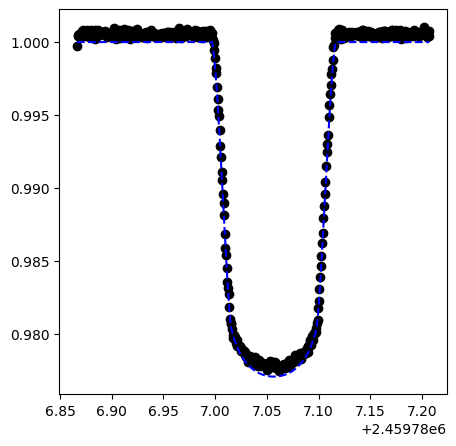

In [135]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))


ax1.plot(time, data.mean(axis=0), 'ko')
ax1.plot(time, model_logdens[-1]['y_model']['value'].mean(axis=0), 'b--')

In [136]:
keys = jax.random.split(jax.random.PRNGKey(55), num=3)

soln = optimx.optimize(
    model,
    sites=["logD", "t0"],
    start=init_params,
)(keys[0], time, err, y=data)

soln = optimx.optimize(
    model,
    sites=["depths","b"],
    start=soln,
)(keys[1], time, err, y=data)

soln = optimx.optimize(
    model,
    start=soln,
)(keys[2], time, err, y=data)

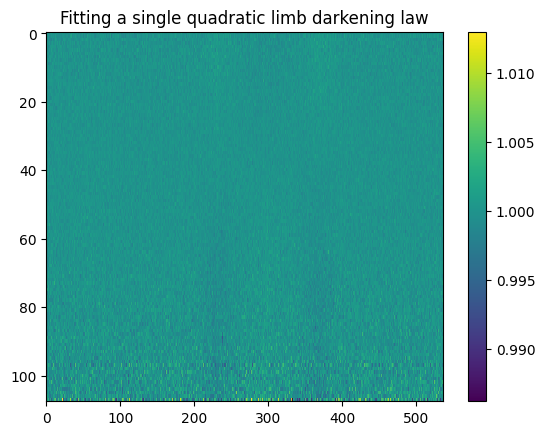

In [138]:
plt.title("Fitting a single quadratic limb darkening law")
plt.imshow(data/soln['y_model'], aspect='auto', interpolation='none', cmap='viridis')
plt.colorbar()

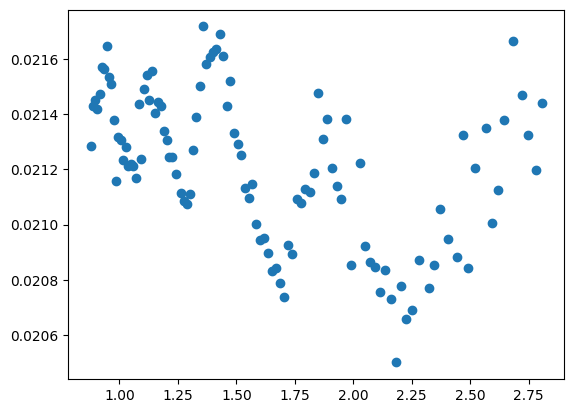

In [140]:
plt.scatter(wmid, soln['depths'])

In [236]:
def model_2param(t, y_err, y=None):

    # Priors

    ## Parameters shared across spectroscopic light curves
    logD = numpyro.sample("logD", dist.Normal(jnp.log(init_white_lc_params['duration']), 1e-2))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    t0 = numpyro.sample(
        "t0", dist.Normal(init_white_lc_params['t0'], 1e-4)
    )  # We usually have pretty good constraints on t0
    b = numpyro.sample(
        "b",
        dist.TruncatedNormal(init_white_lc_params['b'], 0.1, low=0.0, high=1.0),
    )


    u1 = numpyro.sample("u1", dist.Normal(0., 0.7), sample_shape=(len(wmid),))
    u2 = numpyro.sample("u2", dist.Normal(0.0, 0.7), sample_shape=(len(wmid),))

    u = jnp.stack([u1, u2], axis=1)
    ## Parameters for each light curve
    f0 = numpyro.sample("f0", dist.Normal(jnp.ones_like(wmid), 1e-3*jnp.ones_like(wmid)))

    depths = numpyro.sample(
        "depths",
        dist.TruncatedNormal(
            jnp.square(init_white_lc_params['rors']) * jnp.ones_like(wmid),
            1e-3 * jnp.ones_like(wmid),
            low=0.0,
            high=1.0,
        ),
    )
    rors = jnp.atleast_1d(numpyro.deterministic("rors", jnp.sqrt(depths)))

    params = {
        "period": PERIOD,
        "duration": duration,
        "t0": t0,
        "b": b,
        "u": u,
        "f0": f0,
        "rors": rors,
    }
    y_model = numpyro.deterministic("y_model", jax.vmap(
        eval_limb_dark_light_curve,
        in_axes=(
            {
                "period": None,
                "duration": None,
                "b": None,
                "t0": None,
                "u": 0,
                "f0": 0,
                "rors": 0,
            },
            None,
        ),
    )(params, t))
    numpyro.sample("obs", dist.Normal(y_model, y_err), obs=y)

In [237]:
init_params = {
    "period": PERIOD,
    "logD": jnp.log(DURATION),
    "u1": np.array(h5file['exotic-ld_quad'])[:,0],
    "u2": np.array(h5file['exotic-ld_quad'])[:,1],
    "b": B,
    "t0": T0,
    "f0": jnp.ones_like(wmid),
    "depths": RPRS**2,
}

model_logdens = numpyro.infer.util.log_density(model_2param, model_args=(time, err), model_kwargs={'y':data}, params=init_params)

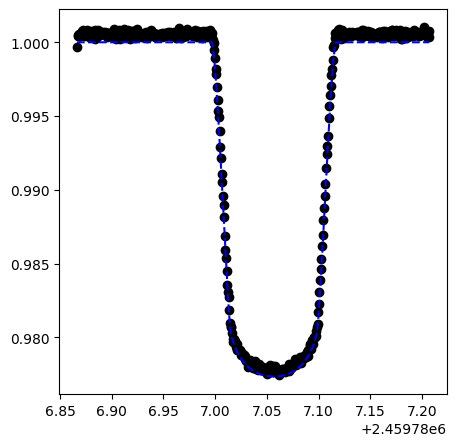

In [238]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))


ax1.plot(time, data.mean(axis=0), 'ko')
ax1.plot(time, model_logdens[-1]['y_model']['value'].mean(axis=0), 'b--')

In [239]:
keys = jax.random.split(jax.random.PRNGKey(55), num=3)

soln = optimx.optimize(
    model_2param,
    sites=["logD", "t0"],
    start=init_params,
)(keys[0], time, err, y=data)

soln = optimx.optimize(
    model_2param,
    sites=["depths","b"],
    start=soln,
)(keys[1], time, err, y=data)

soln = optimx.optimize(
    model_2param,
    start=soln,
)(keys[2], time, err, y=data)

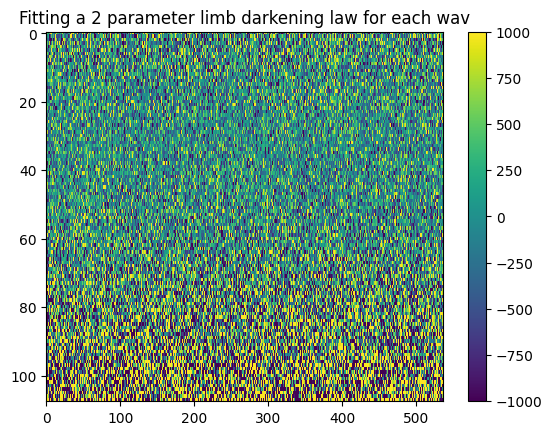

In [240]:
plt.title("Fitting a 2 parameter limb darkening law for each wav")
plt.imshow((data/soln['y_model']-1.0)*1e6, aspect='auto', interpolation='none', cmap='viridis', vmin=-1000, vmax=1000)
plt.colorbar()

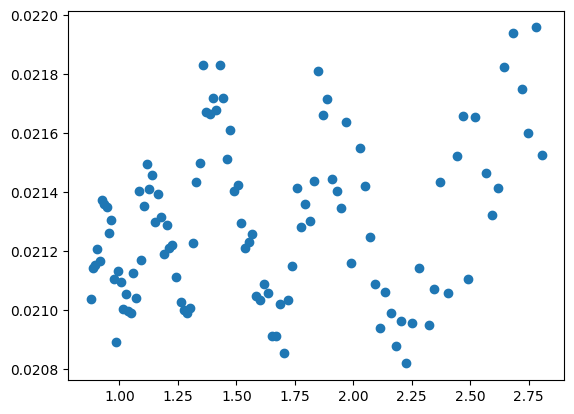

In [241]:
plt.scatter(wmid, soln['depths'])

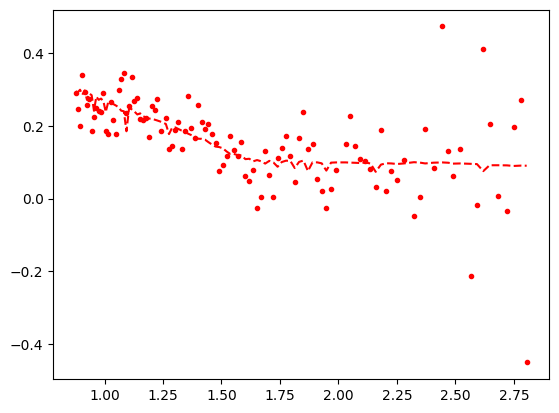

In [245]:
plt.plot(wmid, soln['u1'], 'r.', label='u1')
plt.plot(wmid, np.array(h5file['exotic-ld_quad'])[:,0], 'r--', label='u1 (theory)')

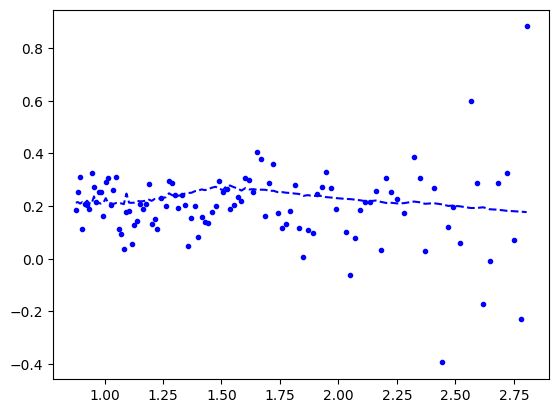

In [246]:
plt.plot(wmid, soln['u2'], 'b.', label='u2')
plt.plot(wmid, np.array(h5file['exotic-ld_quad'])[:,1], 'b--', label='u2 (theory)')

In [247]:
from limb_darkening_fit import four_param_limb_dark
from jaxoplanet.experimental.limb_dark_poly_coeffs import calc_poly_coeffs


u = calc_poly_coeffs(mu, intensity)

In [261]:
def model_4param(t, y_err, y=None):

    # Priors

    ## Parameters shared across spectroscopic light curves
    logD = numpyro.sample("logD", dist.Normal(jnp.log(init_white_lc_params['duration']), 1e-2))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    t0 = numpyro.sample(
        "t0", dist.Normal(init_white_lc_params['t0'], 1e-4)
    )  # We usually have pretty good constraints on t0
    b = numpyro.sample(
        "b",
        dist.TruncatedNormal(init_white_lc_params['b'], 0.1, low=0.0, high=1.0),
    )


    c1 = numpyro.sample("c1", dist.Normal(jnp.array(h5file['exotic-ld_nonlin_4para'])[:,0], 0.5*jnp.ones_like(wmid)))
    c2 = numpyro.sample("c2", dist.Normal(jnp.array(h5file['exotic-ld_nonlin_4para'])[:,1], 0.5*jnp.ones_like(wmid)))
    c3 = numpyro.sample("c3", dist.Normal(jnp.array(h5file['exotic-ld_nonlin_4para'])[:,2], 0.5*jnp.ones_like(wmid)))
    c4 = numpyro.sample("c4", dist.Normal(jnp.array(h5file['exotic-ld_nonlin_4para'])[:,3], 0.5*jnp.ones_like(wmid)))

    mu = jnp.linspace(0, 1, 100)
    intensity = jax.vmap(
        four_param_limb_dark, in_axes=(None, 0)
    )(mu, jnp.array([c1, c2, c3, c4]).T)

    u = jax.vmap(calc_poly_coeffs, in_axes=(None, 0))(mu, intensity)
    ## Parameters for each light curve
    f0 = numpyro.sample("f0", dist.Normal(jnp.ones_like(wmid), 1e-3*jnp.ones_like(wmid)))

    depths = numpyro.sample(
        "depths",
        dist.TruncatedNormal(
            jnp.square(init_white_lc_params['rors']) * jnp.ones_like(wmid),
            1e-3 * jnp.ones_like(wmid),
            low=0.0,
            high=1.0,
        ),
    )
    rors = jnp.atleast_1d(numpyro.deterministic("rors", jnp.sqrt(depths)))

    params = {
        "period": PERIOD,
        "duration": duration,
        "t0": t0,
        "b": b,
        "u": u,
        "f0": f0,
        "rors": rors,
    }
    y_model = numpyro.deterministic("y_model", jax.vmap(
        eval_limb_dark_light_curve,
        in_axes=(
            {
                "period": None,
                "duration": None,
                "b": None,
                "t0": None,
                "u": 0,
                "f0": 0,
                "rors": 0,
            },
            None,
        ),
    )(params, t))
    numpyro.sample("obs", dist.Normal(y_model, y_err), obs=y)

In [262]:
init_params = {
    "period": PERIOD,
    "logD": jnp.log(DURATION),
    "c1": np.array(h5file['exotic-ld_nonlin_4para'])[:,0],
    "c2": np.array(h5file['exotic-ld_nonlin_4para'])[:,1],
    "c3": np.array(h5file['exotic-ld_nonlin_4para'])[:,2],
    "c4": np.array(h5file['exotic-ld_nonlin_4para'])[:,3],
    "b": B,
    "t0": T0,
    "f0": jnp.ones_like(wmid),
    "depths": RPRS**2,
}

model_logdens = numpyro.infer.util.log_density(model_4param, model_args=(time, err), model_kwargs={'y':data}, params=init_params)

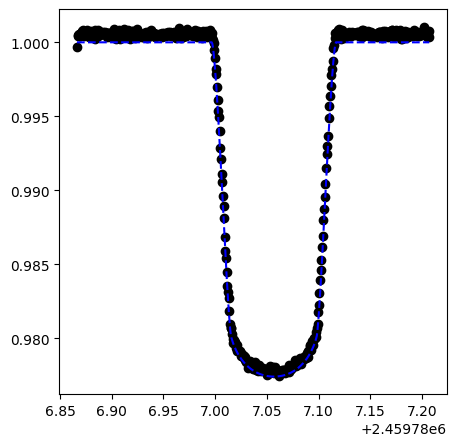

In [263]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))


ax1.plot(time, data.mean(axis=0), 'ko')
ax1.plot(time, model_logdens[-1]['y_model']['value'].mean(axis=0), 'b--')

In [264]:
keys = jax.random.split(jax.random.PRNGKey(55), num=3)

soln = optimx.optimize(
    model_4param,
    sites=["logD", "t0"],
    start=init_params,
)(keys[0], time, err, y=data)

soln = optimx.optimize(
    model_4param,
    sites=["depths","b"],
    start=soln,
)(keys[1], time, err, y=data)

soln = optimx.optimize(
    model_4param,
    start=soln,
)(keys[2], time, err, y=data)

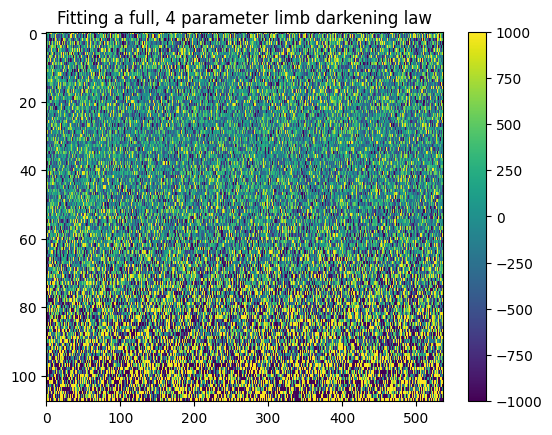

In [265]:
plt.title("Fitting a full, 4 parameter limb darkening law")
plt.imshow((data/soln['y_model']-1.0)*1e6, aspect='auto', interpolation='none', cmap='viridis', vmin=-1000, vmax=1000)
plt.colorbar()

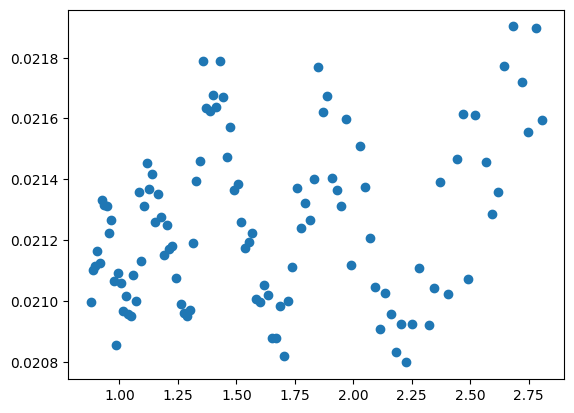

In [266]:
plt.scatter(wmid, soln['depths'])

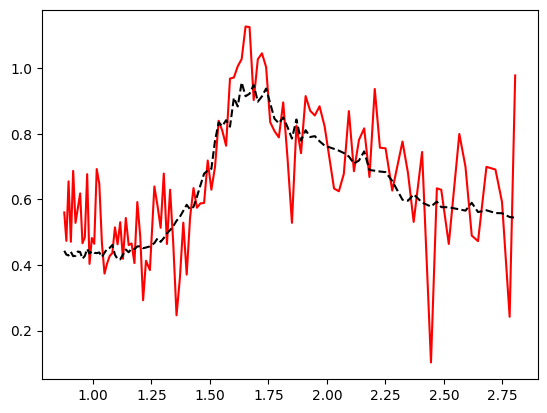

In [267]:
plt.plot(wmid, soln['c1'], 'r-', label='c1')
plt.plot(wmid, np.array(h5file['exotic-ld_nonlin_4para'])[:,0], 'k--', label='c1 (theory)')

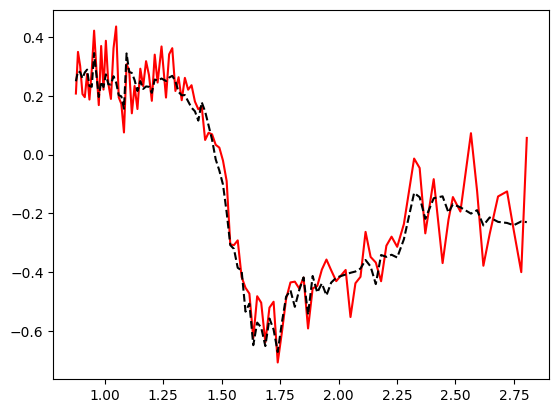

In [268]:
plt.plot(wmid, soln['c2'], 'r-', label='c2')
plt.plot(wmid, np.array(h5file['exotic-ld_nonlin_4para'])[:,1], 'k--', label='c2 (theory)')

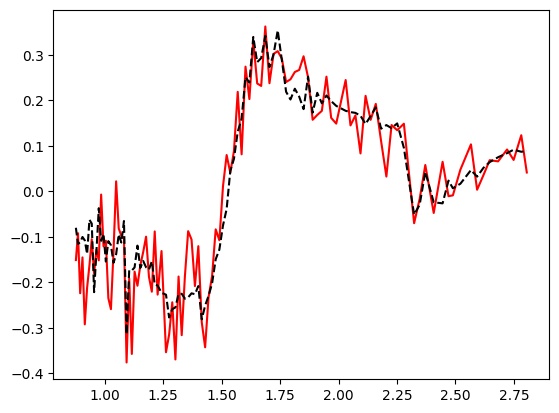

In [269]:
plt.plot(wmid, soln['c3'], 'r-', label='c3')
plt.plot(wmid, np.array(h5file['exotic-ld_nonlin_4para'])[:,2], 'k--', label='c3 (theory)')

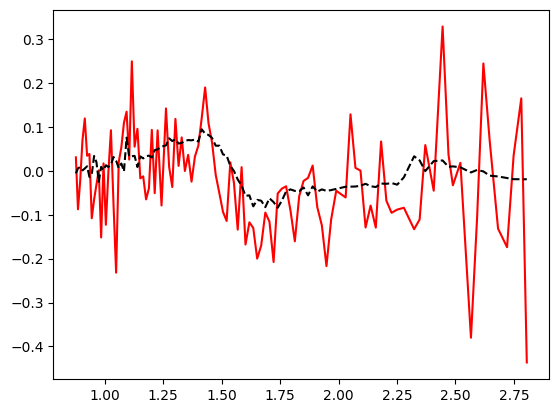

In [271]:
plt.plot(wmid, soln['c4'], 'r-', label='c4')
plt.plot(wmid, np.array(h5file['exotic-ld_nonlin_4para'])[:,3], 'k--', label='c4 (theory)')